<a href="https://colab.research.google.com/github/ParthikB/siamese/blob/master/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


In [0]:
train_data = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test_data  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

BATCH_SIZE = 64
TOTAL_PIXELS = HEIGHT*WIDTH

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

tensor(0)


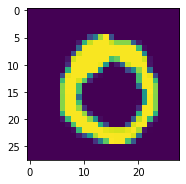

In [134]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch
for batch in trainSet:
    # batch --> one batch containing BATCH_SIZE samples
    x, y = batch[0][i], batch[1][i]
    break

CHANNELS, DIM, DIM = x.shape

plt.subplot(1, 2, 1)
plt.imshow(x.view(HEIGHT, WIDTH)) # Reshaping x from (1, Height, Width) --> (Height, Width)
print(y)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, 512)
    self.fc2   = nn.Linear(512, CLASSES)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):

    x = self.convs(x)
    x = x.view(-1, self.flatten)
    sm = F.relu(self.fc1(x))
    # x = F.softmax(self.fc2(sm), dim=1)
    x = self.fc2(sm)

    return x, sm

In [0]:
def train(net, train_set, loss_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc='Iteration : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        
        # Compute Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
 
    loss_log.append(loss)
  
  return loss_log



def test(net, test_set):
  print('Initiating Testing..')
  correct = 0
  total   = 0

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y):
        pred_class, real_class = output
        pred_class = torch.argmax(pred_class)

      total += 1
      if real_class == pred_class:
        correct += 1

  accuracy = (correct/total)*100
  print()
  print(f'Accuracy : {round(accuracy, 2)} %')
  return accuracy

Initiating Testing..



Accuracy : 99.36 %
Total Epochs : 5


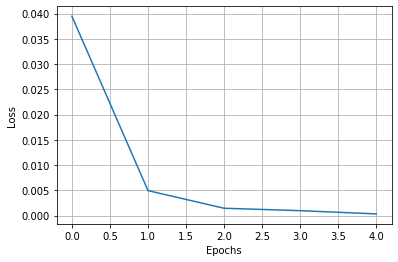

In [136]:
EPOCHS        = 5
LEARNING_RATE = 0.001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log = train(net, trainSet, loss_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.xlabel('Epochs')
plt.ylabel('Loss')

accuracy = test(net, testSet)

print(f'Total Epochs : {total_epochs}')